In [9]:
from ngsolve import *
from netgen.geom2d import *
from nonlin_arnoldis import *
from ngsolve.webgui import Draw
import numpy as np
from netgen.occ import *
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot,show,xlim,ylim,legend
from fem1d import geo1d

In [10]:
maxh = 0.5    #mesh-size
order = 4     #fem order
shift = 4-0.5j      #shift for Arnoldi algorithm

#omega has to be =1 for EV problem
omega = 1
center = (0,0)    #center of inner circle
center2 = (+0.2,0.3)
R = 1           #radius of inner circle
R2 = 0.2

#params for complex scaling
alpha = 5.0
gamma = 0.0

#create geometry
circle = Circle(center, R).Face()
circle.edges.name = 'Gamma'
circle.faces.name ='inner'

circle2 = Circle(center2, R2).Face()


geo = OCCGeometry(circle-circle2, dim=2)
#geo = OCCGeometry(circle, dim=2)


#create mesh
mesh = Mesh(geo.GenerateMesh(maxh=maxh))
mesh.Curve(2*order)

Draw(mesh, order=order)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene



### Complex Scaling 

For this example we implement a **frequency-dependent complex scaling** transformation:

$$\sigma(\omega) := 1 + \frac{\alpha}{\gamma - i\omega} \in \mathbb{C}$$

where $\alpha, \gamma \in \mathbb{R}$.

### Tensor Product Discretization

We implement the star-shaped PML using a **tensor-product approach** for the exterior domain that combines:
- Inherited Surface discrtization of the Interior 2D finite elements on the physical domain
- Radial 1D finite elements for the exterior unbounded region

This approach allows us to handle the unbounded exterior efficiently without explicit meshing.

In [11]:
n = specialcf.normal(2)
v = CoefficientFunction((x,y))          #changing x,y alters middle point of complex scaling   

In [12]:
mesh1d = Mesh(geo1d(0,1).GenerateMesh(maxh=0.1))
fes1d = H1(mesh1d,order=order,complex=True)

N = fes1d.ndof

Gamma = mesh.Boundaries('Gamma')

fes_int = H1(mesh,order=order,complex=True)
fes_surf = H1(mesh,order=order,complex=True,definedon=Gamma)

fes = ProductSpace(fes_int,*( (N-1)*[fes_surf]) )
print("Number of Dofs ", fes.ndof)


Number of Dofs  5230


In [13]:
u,u_ = fes1d.TnT()

fem1d_mass_surf = array(BilinearForm(u*u_*ds('left')).Assemble().mat.ToDense())

fem1d_mass = array(BilinearForm(u*u_*dx).Assemble().mat.ToDense())
fem1d_mass_x = array(BilinearForm(x*u*u_*dx).Assemble().mat.ToDense())
fem1d_mass_xx = array(BilinearForm(x*x*u*u_*dx).Assemble().mat.ToDense())

fem1d_drift = array(BilinearForm(grad(u)*u_*dx).Assemble().mat.ToDense())
fem1d_drift_x = array(BilinearForm(x*grad(u)*u_*dx).Assemble().mat.ToDense())
fem1d_drift_xx = array(BilinearForm(x*x*grad(u)*u_*dx).Assemble().mat.ToDense())

fem1d_laplace = array(BilinearForm(grad(u)*grad(u_)*dx).Assemble().mat.ToDense())
fem1d_laplace_x = array(BilinearForm(x*grad(u)*grad(u_)*dx).Assemble().mat.ToDense())
fem1d_laplace_xx = array(BilinearForm(x*x*grad(u)*grad(u_)*dx).Assemble().mat.ToDense())

used dof inconsistency
(silence this warning by setting BilinearForm(...check_unused=False) )


In [14]:
sig_1 = alpha/(gamma - omega*1j)
sig_a = alpha/(gamma - omega*1j+alpha)

S_rad_1 = (fem1d_laplace - sig_a*fem1d_laplace + 2*fem1d_laplace_x + fem1d_laplace_xx + sig_1*fem1d_laplace_xx
            - 1/4*fem1d_mass - 1/4*sig_1*fem1d_mass
            -1/2*fem1d_mass_surf) 

S_rad_2 = 1*fem1d_mass + sig_1 * fem1d_mass   

D_rad = fem1d_drift + fem1d_drift_x + sig_1 * fem1d_drift_x  

M_rad = (fem1d_mass + sig_1* fem1d_mass
        + 2*fem1d_mass_x + 4 * sig_1 * fem1d_mass_x + 2*sig_1**2 * fem1d_mass_x
        + fem1d_mass_xx + 3*sig_1 * fem1d_mass_xx + 3*sig_1**2*fem1d_mass_xx + sig_1**3 * fem1d_mass_xx)

In [15]:
ds_g = ds(definedon=Gamma)
p,q = fes.TnT()
p_int,q_int = p[0],q[0]

S_form =(
        #interior
        grad(p_int)*grad(q_int)*dx

        #exterior
        +sum(S_rad_1[i,j]*1/(n*v)*p[j]*q[i]*ds_g
           for i in range(N) for j in range(N) if abs(S_rad_1[i,j])>0)
        -sum(D_rad.T[i,j]*1/(n*v)*(v*p[j].Trace().Deriv())*q[i]*ds_g               #be aware fem matrix is transposed, so counterintuitive one is transposed
           for i in range(N) for j in range(N) if abs(D_rad[i,j])>0)
        -sum(D_rad[i,j]*1/(n*v)*p[j]*(v*q[i].Trace().Deriv())*ds_g
           for i in range(N) for j in range(N) if abs(D_rad[i,j])>0)
        +sum(S_rad_2[i,j]*(v*v)/(n*v)*p[j].Trace().Deriv()*q[i].Trace().Deriv()*ds_g
           for i in range(N) for j in range(N) if abs(S_rad_2[i,j])>0)
        -sum(S_rad_2[i,j]*1/(2*n*v)*((p[j].Trace().Deriv()*v)*q[i]+p[j]*(v*q[i].Trace().Deriv()))*ds_g
           for i in range(N) for j in range(N) if abs(S_rad_2[i,j])>0))

M_form =( 
        #interior
        -omega **2 * p_int*q_int*dx

        #exterior
        - omega**2 * sum(M_rad[i,j]*(n*v)*p[j]*q[i]*ds_g
           for i in range(N) for j in range(N) if abs(M_rad[i,j])>0))


We now solve the complex scaled Helmholtz equation:

**Problem:** Find $p \in H^1(\Omega)$, such that 

$$s_{\text{int}}(p, \hat{p}) + s_{\text{ext}}^{\sigma}(p, \hat{p}) - \omega^2 \left( m_{\text{int}}(p, \hat{p}) + m_{\text{ext}}^{\sigma}(p, \hat{p}) \right) = r^{\sigma}(\hat{p})$$

for all $\hat{p} \in H^1(\Omega)$, with

$$\begin{align}
    m_{\mathrm{int}}(\varphi,\psi) &:= \int_{\Omega_{\mathrm{int}}} \varphi(x)\, \psi(x) \,\mathrm{d}x \\
    s_{\mathrm{int}}(\varphi,\psi) &:= \int_{\Omega_{\mathrm{int}}} \nabla \varphi(x) \cdot \nabla \psi(x) \,\mathrm{d}x \\
    m_{\mathrm{ext}}^{\sigma}(\varphi,\psi) &:= \int_{\Omega_{\mathrm{ext}}} \varphi(x)\, \psi(x)\, \det J_{\sigma}(x) \,\mathrm{d}x \\
    s_{\mathrm{ext}}^{\sigma}(\varphi,\psi) &:= \int_{\Omega_{\mathrm{ext}}} 
        \left( J_{\sigma}(x)^{-T} \nabla \varphi(x) \right) 
        \cdot 
        \left( J_{\sigma}(x)^{-T} \nabla \psi(x) \right) 
        \det J_{\sigma}(x) \,\mathrm{d}x \\
    r^{\sigma}(\psi) &:= \int_{\Omega_{\mathrm{int}}} f\, \psi \,\mathrm{d}x
\end{align}$$

In [20]:
f = exp(-((x+0.2)**2 + (y-0.3)**2)/0.2**2)

m_star = BilinearForm(S_form + M_form, symmetric=True).Assemble()
b = LinearForm(f * q_int * dx).Assemble()


gfp = GridFunction(fes)
gfp.vec.data = m_star.mat.Inverse(freedofs=fes.FreeDofs()) * b.vec

Draw(gfp.components[0], mesh, animate_complex = True, order = 6)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Complex': {'phase': 0.0, 's…

BaseWebGuiScene



### Interior Behavior
The solution exhibits natural wave propagation in the interior domain $\Omega_{\text{int}}$.

### Exterior Damping
In the exterior region, the complex scaling transformation introduces **exponential damping**, effectively absorbing outgoing waves.


Since we use a tensor-product approach without explicitly meshing the exterior, we cannot directly visualize the full 3D behavior. Instead, we examine the **radial decay profile** along a specific direction to demonstrate the exponential damping characteristic of the PML.

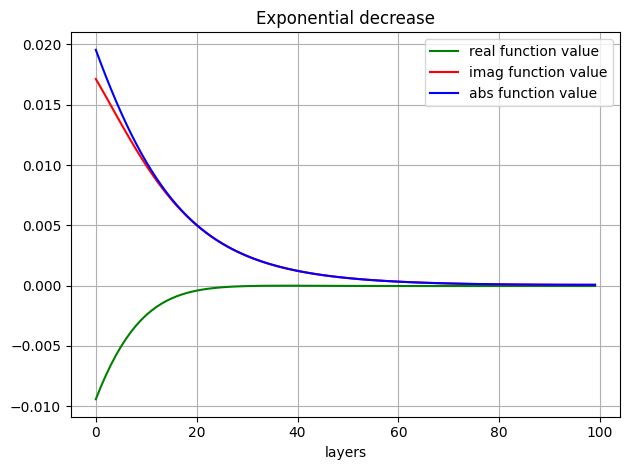

In [21]:
snapshot=[]
p1, p2 = center[0], center[1]
mp = mesh(p1+R,p2,0, BND)
for i in range(N):
    snapshot.append(gfp.components[i](mp))      
     
solution= GridFunction(fes1d)
solution.vec.FV().NumPy()[:] = snapshot

M = 100
xvals = np.linspace(0, 1, M)
yvals_real = [np.real(solution(x)) for x in xvals]
yvals_imag = [np.imag(solution(x)) for x in xvals]
yvals_abs = [np.abs(solution(x)) for x in xvals]

plt.plot(yvals_real, label="real function value", color = 'green')
plt.plot(yvals_imag, label="imag function value", color = 'red')
plt.plot(yvals_abs, label="abs function value", color = 'blue')
plt.xlabel('layers')
plt.legend()
plt.title("Exponential decrease")
plt.grid(True)
plt.tight_layout()
plt.show()

## Eigenvalue Problem 

### Resonance Computation
To validate the correctness of our star-shaped PML method, we solve the corresponding **eigenvalue problem**.

### Reference Solution
Since our computational domain contains a **circular scatterer** (the inner circle), a subset of the computed spectrum must match the **roots of Hankel functions** - these are the analytical resonances for scattering by a circular obstacle.

### Comparison Metrics
- **Computed resonances**: Eigenvalues from our PML discretization
- **Reference resonances**: Zeros of Hankel functions loaded from reference data
- **Essential spectrum**: Theoretical continuous spectrum branch


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Complex': {'phase': 0.0, 's…

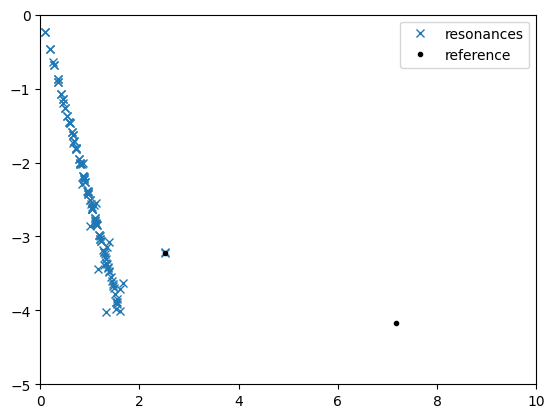

In [22]:

S = BilinearForm(S_form, symmetric = True).Assemble()
M = BilinearForm(M_form, symmetric = True).Assemble()

gf = GridFunction(fes,multidim=120)

#lam = sqrt(array(ArnoldiSolver(S.mat,M.mat,freedofs=fes.FreeDofs(),vecs=list(gf.vecs),shift=shift**2)))
lam = np.sqrt(np.array(PolyArnoldiSolver([S.mat,M.mat],shift**2,300,nevals=120,vecs=gf.vecs,inversetype='sparsecholesky',freedofs=fes.FreeDofs())))

plt.plot(lam.real,lam.imag,'x',label='resonances')

#load reference resonances from file
loaded=np.loadtxt('dhankel_1_zeros.out')
ref=(loaded[:,0]+1j*loaded[:,1])/R2

plt.plot(ref.real,ref.imag,'.k',label='reference')

plt.xlim((0,10))
plt.ylim((-5,0))
plt.legend()
Draw(gf.components[0], animate_complex=True, order=6);            #Vizulazation of eigenfunctions